In [2]:
import pandas as pd
import geopandas as gp
import numpy as np 
import os
import fiona
from statistics import mean, median
import string

# VEST NE 2020

### Races

G20PRERTRU - Donald J. Trump (Republican Party)<br>
G20PREDBID - Joseph R. Biden (Democratic Party)<br>
G20PRELJOR - Jo Jorgensen (Libertarian Party)<br>
G20USSRSAS - Ben Sasse (Republican Party)<br>
G20USSDJAN - Chris Janicek (Democratic Party)<br>
G20USSLSIA - Gene Siadek (Libertarian Party)<br>

Election results from the Nebraska Secretary of State's office via email.
Precinct shapefiles primarily from the U.S. Census Bureau's 2020 Redistricting Data Program, with the following exceptions.

Cass, Douglas, Harlan, and Lancaster replaced with maps from the counties.

Mergers and/or boundary shifts made based on county-sourced maps or geocoded voter files in Adams, Butler, Cuming, Custer, Dakota, Dawes, Dodge, Fillmore, Furnas, Hall, Keith, Keya Paha, Lincoln, Madison, Nemaha, Nuckolls, Phelps, Platte, Richardson, Saline, Scotts Bluff, and Seward.

Some counties reported one or more classes of votes at the county level. These were distributed by candidate based on the precinct-level reported vote.

G20PRERTRU - Donald J. Trump (Republican Party)  
G20PREDBID - Joseph R. Biden (Democratic Party)  
G20PRELJOR - Jo Jorgensen (Libertarian Party)  

G20USSRSAS - Ben Sasse (Republican Party)  
G20USSDJAN - Chris Janicek (Democratic Party)  
G20USSLSLA - Gene Siadek (Libertarian Party)  

## Load in VEST file

In [3]:
vest_ne_2020 = gp.read_file("../vest/ne_2020/ne_2020.shp")

In [4]:
vest_ne_2020

,COUNTY,NAME,G20PRERTRU,G20PREDBID,G20PRELJOR,G20USSRSAS,G20USSDJAN,G20USSLSIA,geometry
0,057,Benkelman I/Ough,332,51,3,308,43,20,"POLYGON Z ((-101.75951 40.34963 0.00000, -101...."
1,057,Benkelman II,295,23,5,281,15,14,"POLYGON Z ((-101.54990 40.09466 0.00000, -101...."
2,057,Benkelman III,147,14,0,136,9,7,"POLYGON Z ((-101.89239 40.34937 0.00000, -101...."
3,057,Haigler,109,17,3,110,10,7,"POLYGON Z ((-102.05197 40.14835 0.00000, -102...."
4,017,City of Ainsworth Precinct,707,101,14,675,68,47,"POLYGON Z ((-99.87398 42.54692 0.00000, -99.87..."
...,...,...,...,...,...,...,...,...,...
1381,055,01-31,538,834,18,642,467,67,"POLYGON Z ((-95.99285 41.34651 0.00000, -95.99..."
1382,055,08-12,736,938,47,833,604,104,"MULTIPOLYGON Z (((-96.04777 41.33416 0.00000, ..."
1383,055,07-35,564,658,26,657,402,51,"POLYGON Z ((-96.14410 41.30250 0.00000, -96.14..."
1384,055,08-13,1102,434,24,1165,239,78,"POLYGON Z ((-96.10087 41.38958 0.00000, -96.10..."


<AxesSubplot:>

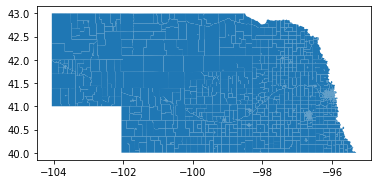

In [5]:
vest_ne_2020.plot()

<AxesSubplot:>

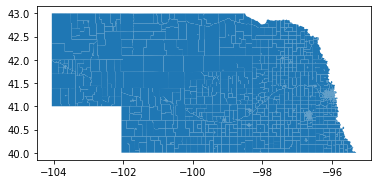

In [6]:
vest_ne_2020.plot()

In [76]:
races = [i for i in vest_ne_2020.columns if "G20P" in i]

## Build precinct results from NE Excel files

In [10]:
PG_COUNTY_RESULTS = 'County Results'
pres_excel_df = pd.read_excel('./raw-data/2020/CountyResults-Presidential.xls')

FileNotFoundError: [Errno 2] No such file or directory: './raw-data/2020/CountyResults-Presidential.xls'

Extract a master list of Nebraska counties from the Presidential results spreadsheet.

In [108]:
import xlrd

# saving files as themselves fixes some weird byte alignment problem in the format that xlrd complains about.
pres_excel_df = pd.read_excel('../raw-data/2020/CountyResults-Presidential-resave.xls', sheet_name='County Results', skiprows=5)

# throw out the bottom three rows (two rows of SOS formatting, one "total" row); extract county list.
pres_excel_df = pres_excel_df.loc[0:len(pres_excel_df)-4]
county_list = list(pres_excel_df['County'])

In [101]:
# The ends of the data tables are not consistent from sheet to sheet. 
# This function finds the correct ending row of a county data set, adds a 'County' column, 
# and returns a cleaned dataframe for this county. 
def process_county_sheet(county_df, county_name):
    # Find the end of this data table by searching for the "TOTAL" row. 
    # Should return a list of exactly one number, which is the row index of the total row. 
    total_row_idx = list(county_excel_df.loc[county_excel_df['Precinct'] == 'TOTAL'].index)
    if len(total_row_idx) != 1:
        raise ValueError("Position of 'TOTAL' row could not be accurately inferred! (Found '{0}' suitable rows.)".format(len(total_row_idx)))

    # keep everything up to the total row; add county name column. 
    county_df = county_excel_df.loc[0:total_row_idx[0]-1].copy()
    county_df['County'] = county_name
    
    # clean leading/trailing whitespace from column names
    county_df.columns = map(lambda e: e.strip(), list(county_df.columns))
    return county_df

Extract the precinct data out of the results spreadsheets, standardize the race results, and create one dataframe for both the Presidential and Senate races. 

In [109]:
# G20PRERTRU - Donald J. Trump (Republican Party)
# G20PREDBID - Joseph R. Biden (Democratic Party)
# G20PRELJOR - Jo Jorgensen (Libertarian Party)
pres_race_map = {
    'Joseph R. Biden and Kamala D. Harris': 'G20PREDBID',
    'Donald J. Trump and Michael R. Pence': 'G20PRERTRU',
    'Jo Jorgensen and Jeremy Cohen': 'G20PRELJOR'
}

# G20USSRSAS - Ben Sasse (Republican Party)
# G20USSDJAN - Chris Janicek (Democratic Party)
# G20USSLSIA - Gene Siadek (Libertarian Party)
sen_race_map = {
    'Gene Siadek': 'G20USSLSIA',
    'Ben Sasse': 'G20USSRSAS',
    'Chris Janicek': 'G20USSDJAN'   
}

# construct each precinct-level county dataframe
pres_county_dfs = []
sen_county_dfs = []
for county in county_list:
    county_excel_df = pd.read_excel('../raw-data/2020/CountyResults-Presidential-resave.xls', sheet_name=county, skiprows=5)
    county_df = process_county_sheet(county_excel_df, county)
    county_df = county_df.rename(columns=pres_race_map)
    county_df = county_df[['County', 'Precinct', 'G20PREDBID', 'G20PRERTRU', 'G20PRELJOR']]
    pres_county_dfs.append(county_df)
    #print("extracted '{0}' county presidential precinct results. (added '{1}' rows)".format(county, len(county_df)))
    
    # senate results
    county_excel_df = pd.read_excel('../raw-data/2020/CountyResults-Senate-resave.xls', sheet_name=county, skiprows=5)
    county_df = process_county_sheet(county_excel_df, county)
    county_df = county_df.rename(columns=sen_race_map)
    county_df = county_df[['County', 'Precinct', 'G20USSDJAN', 'G20USSRSAS', 'G20USSLSIA']]
    sen_county_dfs.append(county_df)
    #print("extracted '{0}' county senate precinct results. (added '{1}' rows)".format(county, len(county_df)))

In [118]:
pres_results_df = pd.concat(pres_county_dfs).reset_index(drop=True)
sen_results_df = pd.concat(sen_county_dfs).reset_index(drop=True)
all_results_df = pres_results_df.merge(sen_results_df, how='left', left_on=['County', 'Precinct'], right_on=['County', 'Precinct'])

In [121]:
all_results_df = pres_results_df.merge(sen_results_df, how='left', left_on=['County', 'Precinct'], right_on=['County', 'Precinct'])


In [122]:
all_results_df.to_csv('../raw-data/2020/statewide-results-by-precinct.csv')

,County,Precinct,G20PREDBID,G20PRERTRU,G20PRELJOR,G20USSDJAN,G20USSRSAS,G20USSLSIA
0,Adams,WestBlue/Highland,50.0,335.0,4.0,38.0,312.0,19.0
1,Adams,Verona,24.0,131.0,3.0,13.0,119.0,14.0
2,Adams,Kenesaw,86.0,556.0,6.0,56.0,507.0,43.0
3,Adams,Juniata,97.0,422.0,12.0,55.0,406.0,42.0
4,Adams,Denver,137.0,495.0,10.0,73.0,490.0,40.0
...,...,...,...,...,...,...,...,...
1594,York,Ward 3,154.0,317.0,13.0,81.0,355.0,29.0
1595,York,Ward 4A,215.0,566.0,27.0,123.0,606.0,45.0
1596,York,Ward 4B,195.0,479.0,25.0,117.0,487.0,42.0
1597,York,New/Former Resident,0.0,4.0,0.0,NaN,NaN,NaN


# START ROWS FROM PETER 1:1

### Load in Raw Election Results

In [15]:
er_2020_df = pd.read_csv('../raw-data/2020/20201103__ne__general__precinct.csv')

In [16]:
er

,county,precinct,office,district,party,candidate,votes
0,Buffalo,Precinct 1,State House,37.0,NaN,John S. Lowe Sr.,722.0
1,Buffalo,Precinct 1,State House,37.0,NaN,Mercadies Damratowski,173.0
2,Buffalo,Precinct 2,State House,37.0,NaN,John S. Lowe Sr.,523.0
3,Buffalo,Precinct 2,State House,37.0,NaN,Mercadies Damratowski,211.0
4,Buffalo,Precinct 3,State House,37.0,NaN,John S. Lowe Sr.,813.0
...,...,...,...,...,...,...,...
12817,Douglas,08~60,State House,7.0,NaN,Jorge Sotolongo,0.0
12818,Douglas,08~61,State House,7.0,NaN,Tony Vargas,0.0
12819,Douglas,08~61,State House,7.0,NaN,Jorge Sotolongo,0.0
12820,Douglas,Countywide,State House,7.0,NaN,Tony Vargas,0.0


In [17]:
er_2020_df["office"].unique()

array(['State House', 'President', 'Senate'], dtype=object)

In [18]:
er_2020_filtered = er_2020_df[er_2020_df["office"].isin(['President'])]

In [19]:
er_2020_filtered["candidate"].unique()

array(['Joseph R. Biden and Kamala D. Harris',
       'Donald J. Trump and Michael R. Pence',
       'Jo Jorgensen and Jeremy Cohen'], dtype=object)

In [22]:
er_2020_filtered["candidate"].unique()

array(['Joseph R. Biden and Kamala D. Harris',
       'Donald J. Trump and Michael R. Pence',
       'Jo Jorgensen and Jeremy Cohen'], dtype=object)

In [23]:
cand_name_changes = {'Donald J. Trump and Michael R. Pence':'G20PRERTRU', 
'Joseph R. Biden and Kamala D. Harris':'G20PREDBID',
'Jo Jorgensen and Jeremy Cohen':'G20PRELJOR'}

er_2020_filtered["candidate"] = er_2020_filtered["candidate"].map(cand_name_changes)

<ipython-input-23-ae8e257cbf98>:5: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  er_2020_filtered["candidate"] = er_2020_filtered["candidate"].map(cand_name_changes)


In [24]:
er_2020_filtered["candidate"].unique()

array(['G20PREDBID', 'G20PRERTRU', 'G20PRELJOR'], dtype=object)

In [25]:
er_2020_filtered

,county,precinct,office,district,party,candidate,votes
2651,Adams,WestBlue/Highland,President,NaN,NaN,G20PREDBID,50.0
2652,Adams,WestBlue/Highland,President,NaN,NaN,G20PRERTRU,335.0
2653,Adams,WestBlue/Highland,President,NaN,NaN,G20PRELJOR,4.0
2654,Adams,Verona,President,NaN,NaN,G20PREDBID,24.0
2655,Adams,Verona,President,NaN,NaN,G20PRERTRU,131.0
...,...,...,...,...,...,...,...
7413,York,New/Former Resident,President,NaN,NaN,G20PRERTRU,4.0
7414,York,New/Former Resident,President,NaN,NaN,G20PRELJOR,0.0
7415,York,Countywide,President,NaN,NaN,G20PREDBID,0.0
7416,York,Countywide,President,NaN,NaN,G20PRERTRU,0.0


In [26]:
er_2020_filtered["pivot_id"] = er_2020_filtered["county"]+"-"+er_2020_filtered["precinct"]

<ipython-input-26-650513afc260>:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  er_2020_filtered["pivot_id"] = er_2020_filtered["county"]+"-"+er_2020_filtered["precinct"]


In [28]:
er_2020_filtered

,county,precinct,office,district,party,candidate,votes,pivot_id
2651,Adams,WestBlue/Highland,President,NaN,NaN,G20PREDBID,50.0,Adams-WestBlue/Highland
2652,Adams,WestBlue/Highland,President,NaN,NaN,G20PRERTRU,335.0,Adams-WestBlue/Highland
2653,Adams,WestBlue/Highland,President,NaN,NaN,G20PRELJOR,4.0,Adams-WestBlue/Highland
2654,Adams,Verona,President,NaN,NaN,G20PREDBID,24.0,Adams-Verona
2655,Adams,Verona,President,NaN,NaN,G20PRERTRU,131.0,Adams-Verona
...,...,...,...,...,...,...,...,...
7413,York,New/Former Resident,President,NaN,NaN,G20PRERTRU,4.0,York-New/Former Resident
7414,York,New/Former Resident,President,NaN,NaN,G20PRELJOR,0.0,York-New/Former Resident
7415,York,Countywide,President,NaN,NaN,G20PREDBID,0.0,York-Countywide
7416,York,Countywide,President,NaN,NaN,G20PRERTRU,0.0,York-Countywide


In [66]:

er_2020_pivoted = pd.pivot_table(er_2020_filtered,index=["pivot_id","precinct","county"],columns=["candidate"],values=['votes'],aggfunc=sum)

In [67]:
er_2020_pivoted.reset_index(inplace=True,drop=False)

In [68]:
er_2020_pivoted.droplevel(1)

IndexError: Too many levels: Index has only 1 level, not 2

In [55]:
er_2020_pivoted.columns = er_2020_pivoted.columns.droplevel(0)

In [70]:
er_2020_pivoted.columns = ["unique_ID","NAME","COUNTY",'G20PREDBID', 'G20PRELJOR', 'G20PRERTRU']

In [71]:
er_2020_pivoted

,unique_ID,NAME,COUNTY,G20PREDBID,G20PRELJOR,G20PRERTRU
0,Adams-1~A,1~A,Adams,252.0,20.0,570.0
1,Adams-1~B,1~B,Adams,187.0,15.0,401.0
2,Adams-1~C,1~C,Adams,222.0,12.0,297.0
3,Adams-2~A,2~A,Adams,77.0,9.0,258.0
4,Adams-2~B,2~B,Adams,176.0,18.0,458.0
...,...,...,...,...,...,...
1579,York-Ward 2A,Ward 2A,York,162.0,18.0,413.0
1580,York-Ward 2B,Ward 2B,York,155.0,25.0,407.0
1581,York-Ward 3,Ward 3,York,154.0,13.0,317.0
1582,York-Ward 4A,Ward 4A,York,215.0,27.0,566.0


In [58]:
def statewide_totals_check(partner_df,source_df,column_list):
    print("***Statewide Totals Check***")
    for race in column_list:
        if (partner_df[race].sum()- source_df[race].sum() != 0):
            print(race+" has a difference of "+str(partner_df[race].sum()-source_df[race].sum())+" votes")
            print("\tVEST: "+str(partner_df[race].sum())+" votes")
            print("\tSOURCES: "+str(source_df[race].sum())+" votes")
        else:
            print(race + " is equal", "\tVEST / RDH: " + str(partner_df[race].sum()))

In [43]:
statewide_totals_check(er_2020_pivoted,vest_ne_2020,races)

***Statewide Totals Check***
G20PRERTRU is equal 	VEST / RDH: 556846.0
G20PREDBID is equal 	VEST / RDH: 374583.0
G20PRELJOR is equal 	VEST / RDH: 20283.0


KeyError: 'G20USSRSAS'

In [44]:
def county_totals_check(partner_df,source_df,column_list,county_col,full_print=False):
    print("***Countywide Totals Check***")
    print("")
    diff_counties=[]
    for race in column_list:
        diff = partner_df.groupby([county_col]).sum()[race]-source_df.groupby([county_col]).sum()[race]
        for val in diff[diff != 0].index.values.tolist():
            if val not in diff_counties:
                diff_counties.append(val)
        if len(diff[diff != 0]!=0):   
            print(race + " contains differences in these counties:")
            for val in diff[diff != 0].index.values.tolist():
                county_differences = diff[diff != 0]
                print("\t"+val+" has a difference of "+str(county_differences[val])+" votes")
                print("\t\tVEST: "+str(partner_df.groupby([county_col]).sum().loc[val,race])+" votes")
                print("\t\tSOURCES: "+str(source_df.groupby([county_col]).sum().loc[val,race])+" votes")
            if (full_print):
                for val in diff[diff == 0].index.values.tolist():
                    county_similarities = diff[diff == 0]
                    print("\t"+val + ": "+ str(partner_df.groupby([county_col]).sum().loc[val,race])+" votes")
        else:
            print(race + " is equal across all counties")
            if (full_print):
                for val in diff[diff == 0].index.values.tolist():
                    county_similarities = diff[diff == 0]
                    print("\t"+val + ": "+ str(partner_df.groupby([county_col]).sum().loc[val,race])+" votes")

In [45]:
vest_ne_2020

,COUNTY,NAME,G20PRERTRU,G20PREDBID,G20PRELJOR,G20USSRSAS,G20USSDJAN,G20USSLSIA,geometry
0,057,Benkelman I/Ough,332,51,3,308,43,20,"POLYGON Z ((-101.75951 40.34963 0.00000, -101...."
1,057,Benkelman II,295,23,5,281,15,14,"POLYGON Z ((-101.54990 40.09466 0.00000, -101...."
2,057,Benkelman III,147,14,0,136,9,7,"POLYGON Z ((-101.89239 40.34937 0.00000, -101...."
3,057,Haigler,109,17,3,110,10,7,"POLYGON Z ((-102.05197 40.14835 0.00000, -102...."
4,017,City of Ainsworth Precinct,707,101,14,675,68,47,"POLYGON Z ((-99.87398 42.54692 0.00000, -99.87..."
...,...,...,...,...,...,...,...,...,...
1381,055,01-31,538,834,18,642,467,67,"POLYGON Z ((-95.99285 41.34651 0.00000, -95.99..."
1382,055,08-12,736,938,47,833,604,104,"MULTIPOLYGON Z (((-96.04777 41.33416 0.00000, ..."
1383,055,07-35,564,658,26,657,402,51,"POLYGON Z ((-96.14410 41.30250 0.00000, -96.14..."
1384,055,08-13,1102,434,24,1165,239,78,"POLYGON Z ((-96.10087 41.38958 0.00000, -96.10..."


In [46]:
er_2020_pivoted

,unique_ID,G20PREDBID,G20PRELJOR,G20PRERTRU
0,Adams-1~A,252.0,20.0,570.0
1,Adams-1~B,187.0,15.0,401.0
2,Adams-1~C,222.0,12.0,297.0
3,Adams-2~A,77.0,9.0,258.0
4,Adams-2~B,176.0,18.0,458.0
...,...,...,...,...
1579,York-Ward 2A,162.0,18.0,413.0
1580,York-Ward 2B,155.0,25.0,407.0
1581,York-Ward 3,154.0,13.0,317.0
1582,York-Ward 4A,215.0,27.0,566.0


In [48]:
vest_ne_2020["unique_ID"] = vest_ne_2020["COUNTY"]+"-"+vest_ne_2020["NAME"]

In [50]:
#Attempt to merge
merge_attempt_one = pd.merge(vest_ne_2020,er_2020_pivoted,how="outer",indicator=True,validate="1:1")

In [51]:
merge_attempt_one["_merge"].value_counts()

right_only    1584
left_only     1386
both             0
Name: _merge, dtype: int64

In [63]:
list(er_2020_pivoted["NAME"].unique())

['1~A',
 '1~B',
 '1~C',
 '2~A',
 '2~B',
 '2~C',
 '2~D',
 '2~E',
 '3~A',
 '3~B',
 '3~C',
 '3~D',
 '3~E',
 '4~A',
 '4~B',
 '4~C',
 '4~D',
 '4~E',
 'Ayr',
 'Blaine',
 'Countywide',
 'Denver',
 'Holstein',
 'Juniata',
 'Kenesaw',
 'New/Former Resident',
 'Pauline',
 'Roseland',
 'Verona',
 'WestBlue/Highland',
 'Brunswick Precinct',
 'Clearwater Precinct',
 'Elgin 1st Ward',
 'Elgin 2nd Ward',
 'Elgin Precinct',
 'Neligh 1st Ward',
 'Neligh 2nd Ward',
 'Neligh Precinct',
 'Oakdale Precinct',
 'Orchard Precinct',
 'Royal Precinct',
 'Tilden 1st Ward',
 'Tilden Precinct',
 'Arthur',
 'Long Springs',
 'Beaver',
 'Boone',
 'Cedar',
 'Dublin~Bonanza',
 'North Branch~Shell Creek',
 'North Manchester',
 'Oakland',
 'Southeast Manchester',
 'Southwest Manchester',
 'Precinct 1',
 'Precinct 11',
 'Precinct 12',
 'Precinct 15',
 'Precinct 2',
 'Precinct 3',
 'Precinct 4',
 'Precinct 5',
 'Precinct 6',
 'Butte Basin McCulley',
 'Lynch Bristow Mullen Bush',
 'Spencer Morton',
 'Ainsworth Precinct',
 '

In [72]:
er_2020_countywide = er_2020_pivoted[er_2020_pivoted["NAME"]=='Countywide']
er_2020_precinct = er_2020_pivoted[er_2020_pivoted["NAME"]!='Countywide']

In [73]:
er_2020_pivoted

,unique_ID,NAME,COUNTY,G20PREDBID,G20PRELJOR,G20PRERTRU
0,Adams-1~A,1~A,Adams,252.0,20.0,570.0
1,Adams-1~B,1~B,Adams,187.0,15.0,401.0
2,Adams-1~C,1~C,Adams,222.0,12.0,297.0
3,Adams-2~A,2~A,Adams,77.0,9.0,258.0
4,Adams-2~B,2~B,Adams,176.0,18.0,458.0
...,...,...,...,...,...,...
1579,York-Ward 2A,Ward 2A,York,162.0,18.0,413.0
1580,York-Ward 2B,Ward 2B,York,155.0,25.0,407.0
1581,York-Ward 3,Ward 3,York,154.0,13.0,317.0
1582,York-Ward 4A,Ward 4A,York,215.0,27.0,566.0


In [77]:
def allocate_absentee(df_receiving_votes,df_allocating,column_list,col_allocating):
    original_cols = list(df_receiving_votes.columns)
    
    #Add in the "Total Votes column"
    df_receiving_votes.loc[:,"Total_Votes"]=0
    for race in column_list:
        df_receiving_votes.loc[:,"Total_Votes"]+=df_receiving_votes.loc[:,race]
    
    #Create the needed dataframes
    precinct_specific_totals = pd.DataFrame(df_receiving_votes.groupby([col_allocating]).sum())
    precinct_specific_totals.reset_index(drop=False,inplace=True)
    to_dole_out_totals = pd.DataFrame(df_allocating.groupby([col_allocating]).sum())
    to_dole_out_totals.reset_index(drop=False,inplace=True)
    
    #Print out any instances where the allocation, as written, won't work
    special_allocation_needed = []
    for index, row in precinct_specific_totals.iterrows():
        for race in column_list:
            if (row[race]==0):
                race_district = row[col_allocating]
                if race_district in to_dole_out_totals[col_allocating].unique():
                    to_allocate = int(to_dole_out_totals.loc[to_dole_out_totals[col_allocating]==race_district][race])
                    if (to_allocate != 0):
                        special_allocation_needed.append([race_district,race])
    
    #Create some new columns for each of these races to deal with the allocation
    for race in column_list:
        add_var = race+"_add"
        rem_var = race+"_rem"
        floor_var = race+"_floor"
        df_receiving_votes.loc[:,add_var]=0.0
        df_receiving_votes.loc[:,rem_var]=0.0
        df_receiving_votes.loc[:,floor_var]=0.0

    #Iterate over the rows
    #Note this function iterates over the dataframe two times so the rounded vote totals match the totals to allocate
    for index, row in df_receiving_votes.iterrows():
        if row[col_allocating] in to_dole_out_totals[col_allocating].unique():
            for race in column_list:
                add_var = race+"_add"
                rem_var = race+"_rem"
                floor_var = race+"_floor"
                #Grab the district
                county_id = row[col_allocating]
                if [county_id,race] in special_allocation_needed:
                    #Get the denominator for the allocation - the summed "total votes" for precincts in that grouping
                    denom = precinct_specific_totals.loc[precinct_specific_totals[col_allocating]==county_id]["Total_Votes"]
                    #Get one of the numerators, how many districtwide votes to allocate
                    numer = to_dole_out_totals.loc[to_dole_out_totals[col_allocating]==county_id][race]
                    #Get the "total votes" for this particular precinct
                    val = df_receiving_votes.at[index,"Total_Votes"]
                    #Get the vote share, the precincts % of total precinct votes in the district times votes to allocate
                else:
                    #Get the denominator for the allocation (the precinct vote totals)
                    denom = precinct_specific_totals.loc[precinct_specific_totals[col_allocating]==county_id][race]
                    #Get one of the numerators, how many districtwide votes to allocate
                    numer = to_dole_out_totals.loc[to_dole_out_totals[col_allocating]==county_id][race]
                    #Get the vote totals for this race in this precinct
                    val = df_receiving_votes.at[index,race]
                    #Get the vote share, the precincts % of total precinct votes in the district times votes to allocate
                if ((float(denom)==0)):
                    vote_share = 0
                else:
                    vote_share = (float(val)/float(denom))*float(numer)
                df_receiving_votes.at[index,add_var] = vote_share
                #Take the decimal remainder of the allocation
                df_receiving_votes.at[index,rem_var] = vote_share%1
                #Take the floor of the allocation
                df_receiving_votes.at[index,floor_var] = np.floor(vote_share)

    #After the first pass through, get the sums of the races by district to assist in the rounding            
    first_allocation = pd.DataFrame(df_receiving_votes.groupby([col_allocating]).sum())

    #Now we want to iterate district by district to work on rounding
    county_list = list(to_dole_out_totals[col_allocating].unique()) 

    #Iterate over the district
    for county in county_list:
        for race in column_list:
            add_var = race+"_add"
            rem_var = race+"_rem"
            floor_var = race+"_floor"
            #County how many votes still need to be allocated (because we took the floor of all the initial allocations)
            to_go = int(np.round((int(to_dole_out_totals.loc[to_dole_out_totals[col_allocating]==county][race])-first_allocation.loc[first_allocation.index==county,floor_var])))
            #Grab the n precincts with the highest remainders and round these up, where n is the # of votes that still need to be allocated
            for index in df_receiving_votes.loc[df_receiving_votes[col_allocating]==county][rem_var].nlargest(to_go).index:
                df_receiving_votes.at[index,add_var] = np.ceil(df_receiving_votes.at[index,add_var])

    #Iterate over every race again
    for race in column_list:
        add_var = race+"_add"
        #Round every allocation down to not add fractional votes
        df_receiving_votes.loc[:,add_var]=np.floor(df_receiving_votes.loc[:,add_var])
        df_receiving_votes.loc[:,race]+=df_receiving_votes.loc[:,add_var]
        df_receiving_votes.loc[:,race] = df_receiving_votes.loc[:,race].astype(int)
        
    df_receiving_votes = df_receiving_votes[original_cols]
    
    return df_receiving_votes

In [78]:
ne_allocated = allocate_absentee(er_2020_precinct,er_2020_countywide,races,"COUNTY")

In [81]:
sum(er_2020_precinct["G20PREDBID"])

374562

In [82]:
sum(ne_allocated["G20PREDBID"])

374562